<a href="https://colab.research.google.com/github/Siuuuuuu0/ML-DL/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
train_data  = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_data  = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 230kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.28MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.3MB/s]


In [11]:
class_names = train_data.classes

In [6]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [12]:
img, label = train_data[0]

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

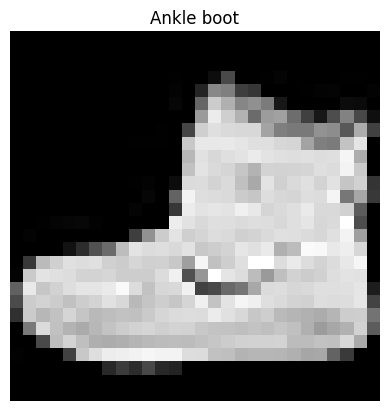

In [13]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

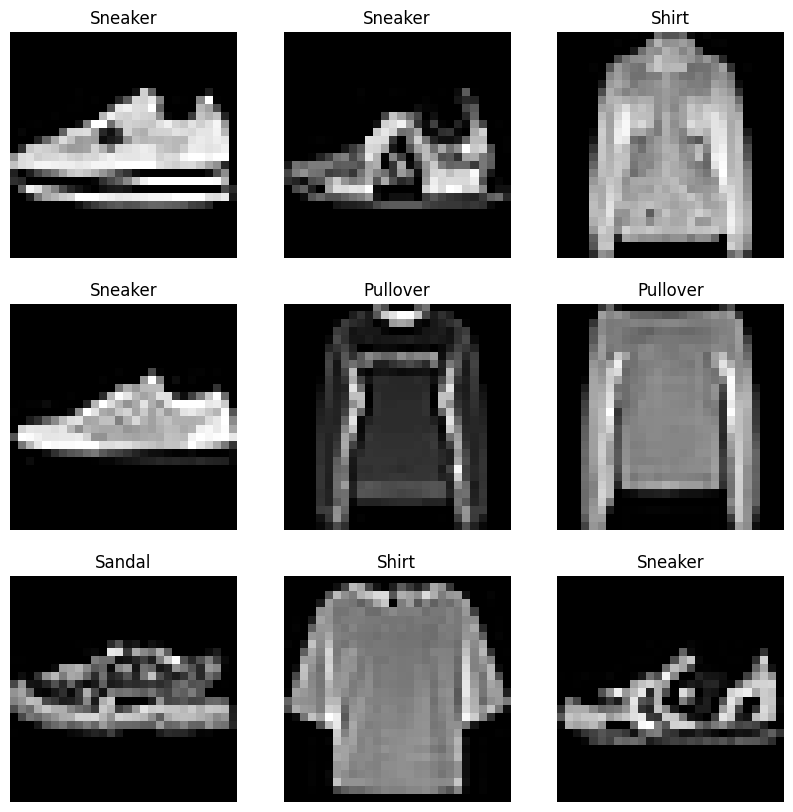

In [15]:
torch.manual_seed(52)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(3):
  for j in range(3):
    idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[idx]
    axes[i, j].imshow(img.squeeze(), cmap="gray")
    axes[i, j].set_title(class_names[label])
    axes[i, j].axis(False)

In [17]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)